Base directory will contain all the 5 BBBD datasets, and will be created in this current directory unless changed to a different location

In [1]:
base_dir = r'.\bbbd_datasets' # '/path/to/downloads/directory'

Function to download and unzip each experiment's dataset

In [2]:
import requests
import zipfile
import os

def bbbd_download_unzip(expno, output_dir, output_file=None):
    url = f'https://fcp-indi.s3.amazonaws.com/data/Projects/CUNY_MADSEN/BBBD/bids_data/experiment{expno}.zip'
    if output_file is None:
        output_file = os.path.join(output_dir, url.split("/")[-1])
    os.makedirs(output_dir, exist_ok=True)
    
    # Download 
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_file, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Download completed: {output_file}")
    else:
        print(f"Failed to download. Status code: {response.status_code}")
        return None
    
    # Unzip
    if zipfile.is_zipfile(output_file):
        print(f"Unzipping {output_file}...")
        with zipfile.ZipFile(output_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Extracted to: {output_dir}")
        os.remove(output_file)
    else:
        print(f"{output_file} is not a ZIP file, skipping extraction.")
    return output_file

Download all 5 datasets to the base_dir by running the cell below

In [ ]:
expnos = [1,2,3,4,5]
for expno in expnos:
    bbbd_download_unzip(expno, base_dir)

Run this command in your terminal to install the packages if you do not have them 

pip install pandas numpy seaborn matplotlib scipy mne

Imports

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

In [3]:
def hr_per_subject(bids_dir):
    hr_results = {
        'ses-01': {},  
        'ses-02': {}  
    }

    subdirs = os.listdir(bids_dir)

    for session in hr_results.keys():
        for sub in subdirs:
            session_path = os.path.join(bids_dir, sub, session, 'beh', '*heartrate.tsv.gz')
            hr_files = glob.glob(session_path)  

            subj_hr = []
            for hr_file in hr_files:
                hr_data = pd.read_csv(hr_file, sep='\t', compression='gzip', header=None)
                hr_column = hr_data.iloc[:, 0] 
                median_hr = np.median(hr_column)

                if not np.isnan(median_hr) and median_hr != 0:
                    subj_hr.append(median_hr)

            if subj_hr:
                hr_results[session][sub] = np.mean(subj_hr)

    return hr_results

def hrv_per_subject(bids_dir):
    hrv_results = {
        'ses-01': {},  # Attend
        'ses-02': {}   # Distract
    }

    subdirs = os.listdir(bids_dir)

    for session in hrv_results.keys():
        for sub in subdirs:
            session_path = os.path.join(bids_dir, sub, session, 'beh', '*rpeak_timestamps.tsv.gz')
            hr_files = glob.glob(session_path)  
            subj_hrv = []

            for hr_file in hr_files:
                try:
                    hr_data = pd.read_csv(hr_file, sep='\t', compression='gzip')
                    hr_column = hr_data.iloc[:, 0] 
                    rmssd = np.sqrt(np.mean(np.diff(hr_column)**2))  # RMSSD
                    subj_hrv.append(rmssd)

                except Exception as e:
                    print(f"Error processing file {hr_file}: {e}")
                    continue
                
            if len(subj_hrv) > 0:
                hrv_results[session][sub] = np.mean(subj_hrv)
    return hrv_results

def pupil_iqr_per_subject(bids_dir):
    iqr_results = {
        'ses-01': {},  
        'ses-02': {}  
    }
    subdirs = os.listdir(bids_dir)
    for session in iqr_results.keys():
        for sub in subdirs:
            session_path = os.path.join(bids_dir, sub, session, 'eyetrack', '*pupil_eyetrack.tsv.gz')
            hr_files = glob.glob(session_path)  
            subj_iqr = []
            for hr_file in hr_files:
                hr_data = pd.read_csv(hr_file, sep='\t', compression='gzip', header=None)
                hr_column = hr_data.iloc[:, 0] 
                q75, q25 = np.percentile(hr_column, [75 ,25])
                iqr = q75 - q25
                if not np.isnan(iqr) and iqr != 0:
                    subj_iqr.append(iqr)
            if subj_iqr:
                iqr_results[session][sub] = np.mean(subj_iqr)
    return iqr_results

def saccaderate_per_subject(bids_dir):
    sr_results = {
        'ses-01': {},  
        'ses-02': {}  
    }
    subdirs = os.listdir(bids_dir)
    for session in sr_results.keys():
        for sub in subdirs:
            session_path = os.path.join(bids_dir, sub, session, 'eyetrack', '*saccaderate.tsv.gz')
            cont_files = glob.glob(session_path)  # Continuous file to compute duration
            disc_path = os.path.join(bids_dir, sub, session, 'eyetrack', '*saccades.tsv.gz')
            disc_files = glob.glob(disc_path) # Discrete file to compute total saccades
            subj_sr = []
            for cont_file, disc_file in zip(cont_files, disc_files):
                cont_data = pd.read_csv(cont_file, sep='\t', compression='gzip', header=None)
                disc_data = pd.read_csv(disc_file, sep='\t', compression='gzip')
                duration = (len(cont_data)/128)/60
                saccaderate = len(disc_data)/duration
                if not np.isnan(saccaderate) and saccaderate != 0:
                    subj_sr.append(saccaderate)
            if subj_sr:
                sr_results[session][sub] = np.mean(subj_sr)
    return sr_results

def blinkrate_per_subject(bids_dir):
    blink_results = {
        'ses-01': {},  
        'ses-02': {}  
    }
    subdirs = os.listdir(bids_dir)
    for session in blink_results.keys():
        for sub in subdirs:
            session_path = os.path.join(bids_dir, sub, session, 'eyetrack', '*blinkrate.tsv.gz')
            cont_files = glob.glob(session_path)  # Continuous file to compute duration
            disc_path = os.path.join(bids_dir, sub, session, 'eyetrack', '*blinks.tsv.gz')
            disc_files = glob.glob(disc_path) # Discrete file to compute total blinks
            subj_blinkrate = []
            for cont_file, disc_file in zip(cont_files, disc_files):
                cont_data = pd.read_csv(cont_file, sep='\t', compression='gzip', header=None)
                disc_data = pd.read_csv(disc_file, sep='\t', compression='gzip')
                
                duration = (len(cont_data)/128)/60
                blinkrate = len(disc_data)/duration

                if not np.isnan(blinkrate) and blinkrate != 0:
                    subj_blinkrate.append(blinkrate)
            if subj_blinkrate:
                blink_results[session][sub] = np.mean(subj_blinkrate)
    return blink_results

def violin_df(exp_dict):
    ses_01 = exp_dict['ex4']['ses-01']
    ses_02 = exp_dict['ex4']['ses-02']
    combined_session = {
        sub: np.mean([ses_01.get(sub, np.nan), ses_02.get(sub, np.nan)])
        for sub in set(ses_01.keys()).union(ses_02.keys())
    }
    exp_dict['ex4']['ses-01'] = combined_session
    del exp_dict['ex4']['ses-02']
    rows = []
    for ex, sessions in exp_dict.items():
        for session, subjects in sessions.items():
            for sub, value in subjects.items():
                rows.append({'Experiment': ex, 'Session': session, 'Subject': sub, 'Value': value})

    return pd.DataFrame(rows)

def violin_plot_heart(df, attentive_color, distract_color, intervention_color, plot_label):
    experiments = df['Experiment'].unique()
    fig, axes = plt.subplots(1, len(experiments), gridspec_kw={'width_ratios': [2, 2, 1, 2]}, figsize=(14, 4), sharey=True)
    for i, ex in enumerate(experiments):
        ax = axes[i] if len(experiments) > 1 else axes  # Handle single subplot case
        ex_data = df[df['Experiment'] == ex]
        sessions = ['ses-01', 'ses-02']
        exp_sessions = ['Attentive', 'Distracted']
        if i == 2:
            sessions = ['ses-01']
            exp_sessions = ['Attentive']
        if i==3:
            sessions = ['ses-01', 'ses-02']
            exp_sessions = ['Attentive', 'Intervention']
        
        positions = range(len(sessions))

        for j, session in enumerate(sessions):
            session_data = ex_data[ex_data['Session'] == session]
            if session_data.empty:
                print(f"No data for {ex} {session}")
                continue  

            if i==3:
                sns.violinplot(x=[session] * len(session_data), y=session_data['Value'], ax=ax,
                            inner=None, color=intervention_color if session != 'ses-01' else attentive_color, linewidth=1.5)
            else:
                sns.violinplot(x=[session] * len(session_data), y=session_data['Value'], ax=ax,
                                inner=None, color=distract_color if session != 'ses-01' else attentive_color, linewidth=1.5)

        subjects = ex_data['Subject'].unique()
        for sub in subjects:
            sub_data = ex_data[ex_data['Subject'] == sub]
            x = [sessions.index(s) for s in sub_data['Session']]
            y = sub_data['Value']
            ax.plot(x, y, marker='o', linestyle='-', color='black', alpha=0.5)

        ax.set_title(f"Experiment {i+2}", fontsize=12)
        ax.set_xticks(positions)
        ax.set_xticklabels(exp_sessions, fontsize=12)
        ax.set_ylabel('')

    fig.text(0.04, 0.5, plot_label, va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()
    
def violin_plot_eye(df, attentive_color, distract_color, intervention_color, plot_label):
    experiments = df['Experiment'].unique()
    fig, axes = plt.subplots(1, len(experiments), gridspec_kw={'width_ratios': [2, 2, 2, 1, 2]}, figsize=(14, 4), sharey=False)
    for i, ex in enumerate(experiments):
        ax = axes[i] if len(experiments) > 1 else axes  # Handle single subplot case
        ex_data = df[df['Experiment'] == ex]
        sessions = ['ses-01', 'ses-02']
        exp_sessions = ['Attentive', 'Distracted']
        if i == 3:
            sessions = ['ses-01']
            exp_sessions = ['Attentive']
        if i==4:
            sessions = ['ses-01', 'ses-02']
            exp_sessions = ['Attentive', 'Intervention']

        positions = range(len(sessions))

        for j, session in enumerate(sessions):
            session_data = ex_data[ex_data['Session'] == session]
            if session_data.empty:
                print(f"No data for {ex} {session}")
                continue  
            if i==4:
                sns.violinplot(x=[session] * len(session_data), y=session_data['Value'], ax=ax,
                            inner=None, color=intervention_color if session != 'ses-01' else attentive_color, linewidth=1.5)
            else:
                sns.violinplot(x=[session] * len(session_data), y=session_data['Value'], ax=ax,
                                inner=None, color=distract_color if session != 'ses-01' else attentive_color, linewidth=1.5)
                
        subjects = ex_data['Subject'].unique()
        for sub in subjects:
            sub_data = ex_data[ex_data['Subject'] == sub]
            x = [sessions.index(s) for s in sub_data['Session']]
            y = sub_data['Value']
            ax.plot(x, y, marker='o', linestyle='-', color='black', alpha=0.5)

        ax.set_title(f"Experiment {i+1}", fontsize=12)
        ax.set_xticks(positions)
        ax.set_xticklabels(exp_sessions, fontsize=12)
        ax.set_ylabel('')
        ax.set_yticks([])
        
    fig.text(0.04, 0.5, plot_label, va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()
    
def cohen_d_paired(x,y):
    diff = x-y
    return np.mean(diff)/np.std(diff)
    
def ttest_df(df_measure):
    paired_tests = []
    for experiment, group in df_measure.groupby('Experiment'):
        if experiment == 'ex4':
            continue
        ses1 = group[group['Session'] == 'ses-01'].set_index('Subject')['Value']
        ses2 = group[group['Session'] == 'ses-02'].set_index('Subject')['Value']
        
        common_subjects = ses1.index.intersection(ses2.index)
        ses1 = ses1.loc[common_subjects]
        ses2 = ses2.loc[common_subjects]

        t_stat, p_value = ttest_rel(ses2, ses1)
        df = len(ses2) - 1
        paired_tests.append({
            'Experiment': experiment,
            't_stat': t_stat,
            'p_value': p_value,
            'df': df,
            'd`': cohen_d_paired(ses2,ses1)
        })
    return pd.DataFrame(paired_tests)

def process_and_visualise(bids_directories, experiments, data_function, violin_plot_function, plot_label, colors, stat_label):
    data_dict = {exp: {} for exp in experiments}
    
    for exp_index, bids_directory in enumerate(bids_directories): 
        exp_label = experiments[exp_index]
        data = data_function(bids_directory)
        data_dict[exp_label] = data

    df_data = violin_df(data_dict)
    print(f'{stat_label} Violin Plot')
    violin_plot_function(df_data, **colors, plot_label=plot_label)
    display(ttest_df(df_data))

Heart Rate (mean of medians) Violin Plot


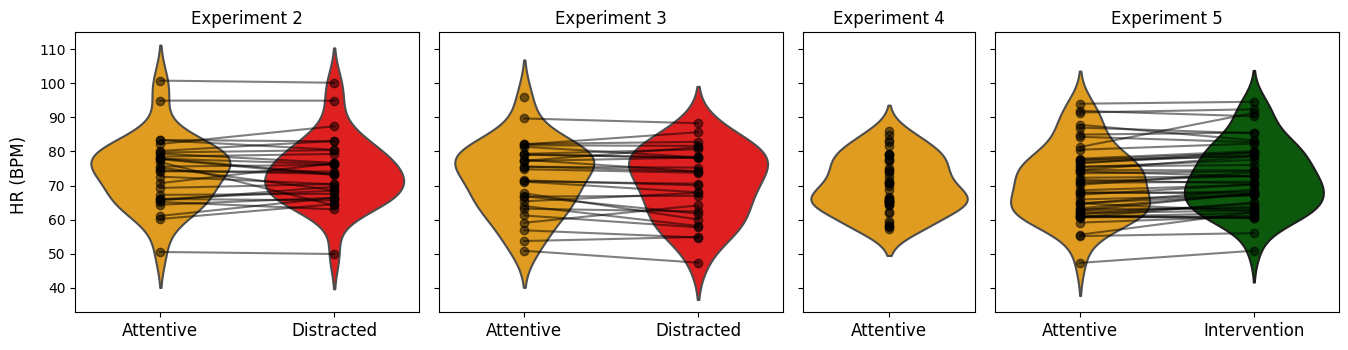

,Experiment,t_stat,p_value,df,d`
0,ex2,-0.366328,0.716874,28,-0.069229
1,ex3,-1.743153,0.092686,27,-0.335470
2,ex5,4.051937,0.000189,47,0.591036


Heart Rate Variability (mean of RMSSDs) Violin Plot


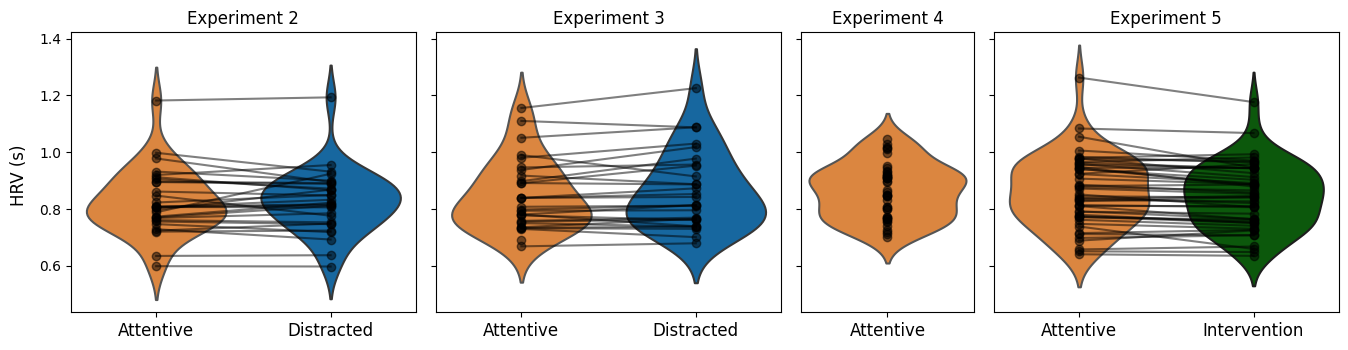

,Experiment,t_stat,p_value,df,d`
0,ex2,0.067224,0.946881,28,0.012704
1,ex3,1.677458,0.104994,27,0.322827
2,ex5,-4.380478,0.000066,47,-0.638958


Pupil Size (mean of IQRs) Violin Plot


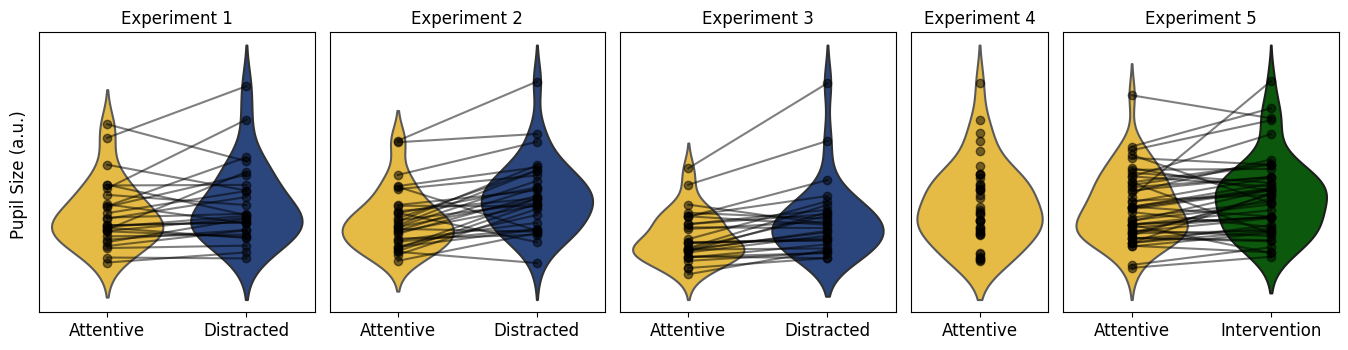

,Experiment,t_stat,p_value,df,d`
0,ex1,1.944580,0.062718,26,0.381364
1,ex2,5.214072,0.000013,30,0.951955
2,ex3,4.083664,0.000355,27,0.785901
3,ex5,2.838339,0.006676,47,0.414014


Blink Rate (mean of (Total Blinks/Duration)) Violin Plot


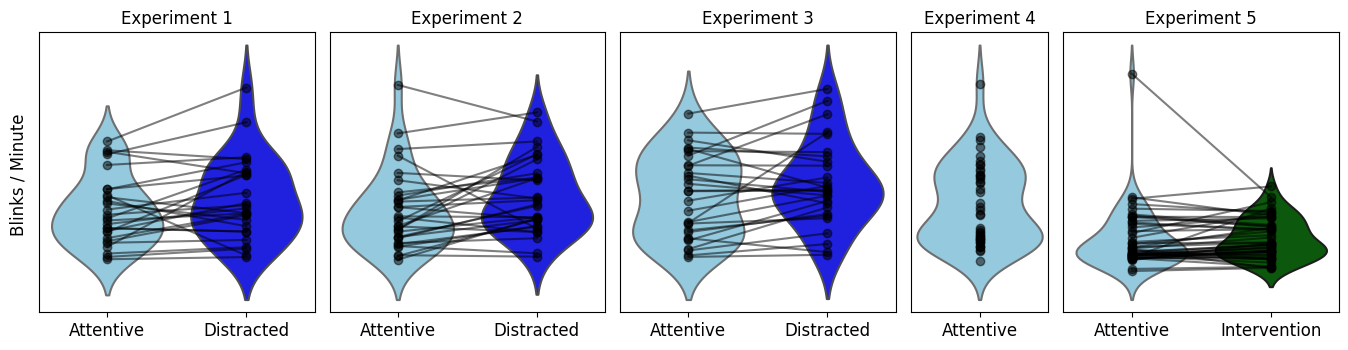

,Experiment,t_stat,p_value,df,d`
0,ex1,2.087668,0.046770,26,0.409425
1,ex2,2.584704,0.014855,30,0.471900
2,ex3,2.043848,0.050836,27,0.393339
3,ex5,0.269594,0.788653,47,0.039324


Saccade Rate (mean of (Total Saccades/Duration)) Violin Plot


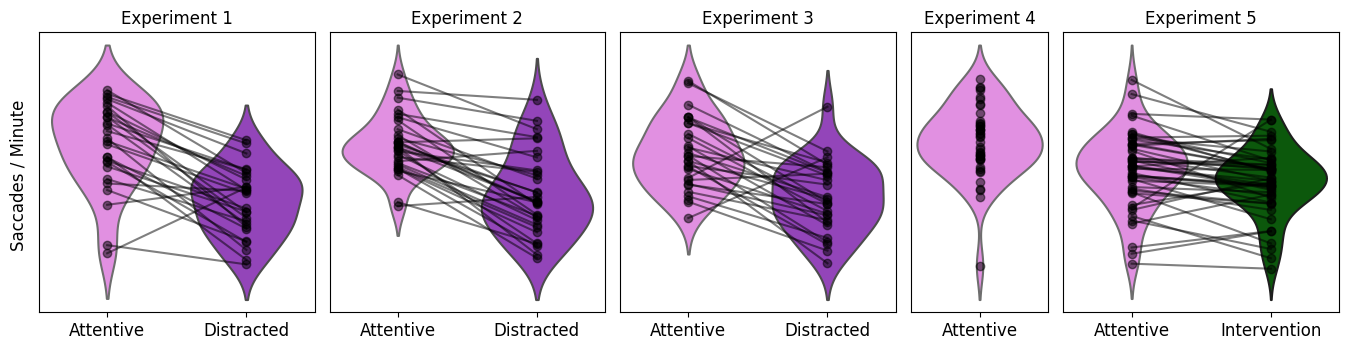

,Experiment,t_stat,p_value,df,d`
0,ex1,-7.280038,9.890265e-08,26,-1.427733
1,ex2,-8.794931,8.328129e-10,30,-1.605727
2,ex3,-5.730968,4.310857e-06,27,-1.102925
3,ex5,-3.458656,1.163983e-03,47,-0.504497


In [4]:
########################################## Heart data ######################################
exp_derivatives_paths = [
    r'experiment2\derivatives',
    r'experiment3\derivatives',
    r'experiment4\derivatives',
    r'experiment5\derivatives',
]

bids_directories_heart = [os.path.join(base_dir, os.path.normpath(path)) for path in exp_derivatives_paths] # Constructing full paths

experiments_heart = [f'ex{i+2}' for i in range(len(bids_directories_heart))]

# Heart Rate
process_and_visualise(bids_directories_heart,experiments_heart,hr_per_subject,violin_plot_heart,"HR (BPM)",{"attentive_color": "orange", "distract_color": "red", "intervention_color": "darkgreen"},"Heart Rate (mean of medians)")

# Heart Rate Variability
process_and_visualise(bids_directories_heart,experiments_heart,hrv_per_subject,violin_plot_heart,"HRV (s)",{"attentive_color": "#F58426", "distract_color": "#006BB6", "intervention_color": "darkgreen"},"Heart Rate Variability (mean of RMSSDs)")



########################################## Eyetracker data ######################################

# Add experiment 1 for eyetracker data
bids_directories_eye = [os.path.join(base_dir, os.path.normpath(r'experiment1\derivatives'))] + bids_directories_heart

experiments_eye = [f'ex{i+1}' for i in range(len(bids_directories_eye))]

# Pupil Size
process_and_visualise(bids_directories_eye,experiments_eye,pupil_iqr_per_subject,violin_plot_eye,"Pupil Size (a.u.)",{"attentive_color": "#FFC72C", "distract_color": "#1D428A", "intervention_color": "darkgreen"},"Pupil Size (mean of IQRs)")

# Blink Rate
process_and_visualise(bids_directories_eye,experiments_eye,blinkrate_per_subject, violin_plot_eye,"Blinks / Minute",{"attentive_color": "skyblue", "distract_color": "blue", "intervention_color": "darkgreen"},"Blink Rate (mean of (Total Blinks/Duration))")

# Saccade Rate
process_and_visualise(bids_directories_eye,experiments_eye,saccaderate_per_subject,violin_plot_eye,"Saccades / Minute",{"attentive_color": "violet", "distract_color": "darkorchid", "intervention_color": "darkgreen"},"Saccade Rate (mean of (Total Saccades/Duration))")


In [5]:
def hr_br_calc(bids_dir, file_type):
    hr_br_results = {
        'ses-01': {},  # Attend
        'ses-02': {}   # Distract
    }
    subdirs = os.listdir(bids_dir)

    for session in hr_br_results.keys():
        for sub in subdirs:
            session_path = os.path.join(bids_dir, sub, session, 'beh', file_type)
            files = glob.glob(session_path)  

            total_weighted_mean = 0
            total_samples = 0

            for file in files:
                try:
                    # Read the HR data
                    data = pd.read_csv(file, sep='\t', compression='gzip', header=None)
                    data_column = data.iloc[:, 0] 
                    mean = np.mean(data_column)  
                    n_samples = len(data_column)

                    if not np.isnan(mean) and n_samples > 1:
                        total_weighted_mean += n_samples * mean
                        total_samples += n_samples 

                except Exception as e:
                    print(f"Error processing file {file}: {e}")
                    continue

            # Calculate weighted mean if data is available
            if total_samples > 0:
                weighted_mean = total_weighted_mean / total_samples
                hr_br_results[session][sub] = weighted_mean
    
    return hr_br_results

# Using only exp 4 and 5 data as they have respiration
hrbr_paths = [r'experiment4\derivatives', r'experiment5\derivatives']
bids_directories_hrbr = [os.path.join(base_dir, os.path.normpath(path)) for path in hrbr_paths]

experiment_labels = ['Exp 4', 'Exp 5']
exp_dict_hr_means = {
    'ex4': {},
    'ex5': {},
}
exp_dict_br_means = {
    'ex4': {},
    'ex5': {},
}

for exp_index, bids_directory in enumerate(bids_directories_hrbr): 
    exp_label = f'ex{exp_index + 4}'  # Creates labels 'ex1', 'ex2', 'ex3'
    print('Experiment: ', exp_label)
    hr_means = hr_br_calc(bids_directory, '*heartrate.tsv.gz')
    exp_dict_hr_means[exp_label] = hr_means
    br_means = hr_br_calc(bids_directory, '*breathrate.tsv.gz')
    exp_dict_br_means[exp_label] = br_means

exp_dict_ratio = {}

for exp in exp_dict_hr_means:
    if exp in exp_dict_br_means: 
        exp_dict_ratio[exp] = {}  
        
        for ses in exp_dict_hr_means[exp]:
            if ses in exp_dict_br_means[exp]: 
                exp_dict_ratio[exp][ses] = {} 
                
                for sub in exp_dict_hr_means[exp][ses]:
                    if sub in exp_dict_br_means[exp][ses]:  
                        hr_value = exp_dict_hr_means[exp][ses][sub]
                        br_value = exp_dict_br_means[exp][ses][sub]
                        exp_dict_ratio[exp][ses][sub] = hr_value / br_value

df_hr_br = violin_df(exp_dict_ratio)


Experiment:  ex4
Experiment:  ex5


C:\Users\Nikhil\AppData\Local\Temp\ipykernel_14532\243611224.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


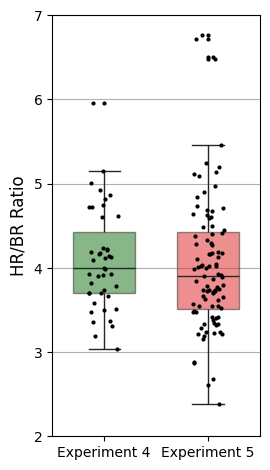

In [6]:
df_hr_br["Experiment"] = df_hr_br["Experiment"].replace({"ex4": "Experiment 4", "ex5": "Experiment 5"})
palette = {'Experiment 4': 'green', 'Experiment 5': 'red'}

# Create a horizontal boxplot with points and error bars
plt.figure(figsize=(2.8, 5))
sns.boxplot(
    data=df_hr_br,
    x='Experiment',  
    y='Value',       
    palette=palette,
    linewidth=1,
    width=0.6,
    boxprops={'alpha': 0.5},
    dodge=False,
    flierprops={
        'marker': 'o',           
        'markersize': 2,        
        'markerfacecolor': 'black',  
        'markeredgecolor': 'black',  
        'alpha': 1               
    },
    orient="v"  # Ensure horizontal orientation
)

sns.stripplot(
    data=df_hr_br,
    x='Experiment', 
    y='Value',       
    color='black',
    alpha=1,
    size=3,
    jitter=0.15  
)

plt.ylabel('HR/BR Ratio', fontsize=12)
plt.ylim(2, 7)  # Set limits for x-axis (HR/BR Ratio) [only for visualization]
plt.gca().set_facecolor('none')  
plt.grid(axis='y')  # Adjust grid to match horizontal orientation
plt.tight_layout()
plt.xlabel('')  

plt.show()
